In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import HTML, display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets

from collections import namedtuple
from functools import partial

from jax import random, jit
from jax.experimental.stax import Relu, Sigmoid, Elu, Selu

from jax_nn import create_mlp, binary_crossentropy_loss
from jax_vae import create_vae
from revise import Revise, trim_path

rng_key = random.PRNGKey(0)

## Project by: 
Lakshman Bana, Justin Clark*, Maria Guramare, Wisoo Song, Jordan Turley

*Interested in research in Spring 2021
## Class:
AM207, Fall 2020

## Paper chosen:

[CRUDS - Counterfactual Recourse Using Disentangled Subspaces](http://whi2020.online/static/pdfs/paper_74.pdf)

# Introduction and paper analysis


## Problem statement
We chose to work with the CRUDS paper which seeks to address the problem of general 
**algorithmic recourse**. 
This poblem involves taking as input a dataset with measurements along a certain number of characteristics
or features, and an output label. The goal is, given some datapoint with a certain classification, to 
generate one or several datapoints with one or more changes in the measured characteristics which, if 
implemented, should yield the opposite classification.
Note that such a point is called a **counterfactual**, and we will be using this terminology throughout 
our project as well.
The new set of characteristics constitute one or more suggestions with the goal of achieving
*recourse* from the current classification.

## Context & scope
The paper seeks to be as general as possible in the types of datasets it is able to perform algorithmic 
recourse on. The whole point of CRUDS is that it only requires labeled datasets with no additional 
knowledge - as opposed to other
current methods which we will discuss more in depth in the next sections. <br>
More generally, algorithmic recourse is a very interesting and useful problem. Its main applications are 
in decision making processes such as loan approval, in which any individual might be in the position
of asking themselves what characteristics they could change in order to change some outcome. Loan approval
is a frequently used example, but other topics of interest can be found in areas other than finance 
such as medication prescription in medicine, college admissions and hiring, and any type of 
"consequential decision-making" problems (Karimi et al.).

## Existing work
There are already many algorithms handling algorithmic recourse, however most of them necessitate large 
amounts of knowledge about the classifiers and the structures and mechanisms explaining the data, which CRUDS'
purpose is to avoid using. The paper therefore mainly analyzes and compares CRUDS' performance to one
other existing algorithm: REVISE. <br>
REVISE is an algorithm which first uses a Variational AutoEncoder (VAE) to derive a latent representation
of the data with the goal of seizing the "underlying strcuture" of the data by encoding each one of the 
latent attributes into a probability distribution. Given some datapoint with a certain classification,
this algorithm then generates a unique counterfactual through gradient descent on the latent representation 
or "latent space". 

## Contribution
As mentioned above, the main gap in current methods which CRUDS is trying to fill is the dependance on 
extensive knowledge of the underlying structures and processes which generated the datasets, relationships
between covariates which do not exclusively stem from measurable metrics, "ground truth classifiers" and 
other characteristics about the input characteristics. CRUDS is an algorithm which needs nothing 
more than the training datapoints and their respective labels, and ensures that peformance as discussed
above is met exclusively through the algorithm's steps.

Another important aspect which CRUDS aims to address is the performance of counterfactual generation with 
respect to a few performance metrics and usability indicators:
- how *actionable* counterfactuals are: as shown in the paper, REVISE and other methods suggest changes 
which cannot be implemented or translated into realistic changes (such as reducing one's age)
- how *valid* counterfactuals are: the goal is that the set of changes suggested are successful in causing
a change in classification when implemented. Unfortunately, for various reasons mainly based on the 
geometry of the space and the data, REVISE sometimes fails to output such valid counterfactuals.
We shall demonstrate this in greater detail through our project.
- how *many* counterfactuals or sets of suggestions are generated: only one counterfactual is outputted by 
REVISE, such that CRUDS seeks to generate a broader set of suggestions that a user might be able to choose 
from
- satisfying constraints: the paper identifies two types of constraints - "causal constraints" and 
"individual constraints". Causal constraints include any type of general, problem or logic-induced 
constraint - for instance, when a change in one characteristic cannot be performed without impacting some 
other charactestic. Individual constraints are quite literally contraints which vary from one person to the
other and are specific to the data point which's classification we are trying to change.
REVISE and other current methods are completely oblivious to either of those types of constraints, and thus
at risk of violating them at any time. Furthermore, by only outputting one counterfactual, if that 
counterfactual suggests chages that are nonsensical or infeasible, nothing can be attempted by a user
of such a system to change their classification

## Technical Content - high level
- using CSVAE as the model generating the latent representation. Major difference with VAE 
is that CSVAE's latent space is separated into one part dedicated to learning those features
which are predictive of the final labels($\mathbf{W}$), and another part dedicated to learning the  
latent representations of features which do not affect the label but explain the underlying
structure of the data/ explain data generation ($\mathbf{Z}$).


<img src="images/VAE_CSVAE_legend.png" height=300>








- adding steps allowing for obeying constraints (causal and individual)  
- preventing common failure modes by not relying on the input space's geometry
- taking into account probability densities to output more "likely" suggestions (regions 
with higher data density )
- outputting a *set* of suggestions instead of one individual one 

## Technical Content - details


### 1. CSVAE

We learned in class that VAE maximizes the ELBO via gradient descent:

$$\log p_{\theta}(x) \geq E_{q_{\phi}(z|x)}[\log p_{\theta}(x|z)] - D_{KL}(q_{\phi}(z|x) || p(z))$$,

 where $\theta$ and $\phi$ denote generative and variational parameters, repectively. 


 In order for CSVAE to disentangle the latent feature space $\mathbf{W}$, it needs to 
 
 1) augment this ELBO to incorporate the additional latent vector $\vec{w}$ and
 
 2) add another objective function expressing the mutual information minimization to control the amount of information about $\vec{y}$ leaked into $\vec{z}.$


#### 1.1 Mutual Information and Conditional Entropy

Mutual information between Y and Z given Z, or $I(Y;Z)$ can be expressed with two entropy terms:

$$I(Y;Z) = H(Y) - H(Y|Z)$$,

where $H(Y)$ is the entropy of random variable $Y$ and $H(Y|Z)$ is the conditional entropy. An important observation is that the first term $H(Y)$ is a constant valued term. 
This is because the entropy $H(Y)$ is defined as $H(Y) = -\sum{p(Y)\log p(Y)}$  and the prior on $Y$ is a fixed value coming from our dataset. 
Thus, minimization of mutual information between $Y$ and $Z$ becomes a problem of maximizing the conditional entropy $H(Y|Z).$
The conditional entropy  $H(Y|Z)$ can be expressed as

$$H(Y|Z)$$
$$=-\int{\int_{Z,Y}{p(\vec{z})p(\vec{y}|\vec{z})\log p(\vec{y}|\vec{z})d\vec{y} d\vec{z}}}$$
$$=-\int{\int{\int_{Z,Y,X}{p(\vec{z}|\vec{x})p(\vec{x})p(\vec{y}|\vec{z})\log p(\vec{y}|\vec{z})d\vec{x} d\vec{y} d\vec{z}}}}.$$

(Note that there is a discrepancy between the equations in this report and the original paper because the CSVAE paper omitted the negative sign by mistake for the double integral expression of conditional entropy.)

Because $\vec{z}$ is a latent variable, we have no means of evaluating the integral over $Z$. Thus, to approximate this quantity we replace $p(\vec{z}|\vec{x})$ and $p(\vec{y}|\vec{z})$ with $q_{\sigma}(\vec{z}|\vec{x})$ and $q_{\sigma}(\vec{y}|\vec{z})$.
Note that this is a similar variational inference trick that was used to derive ELBO for VAE.
This gives us
  
$$\approx E_{D(\vec{x})}[-\int{\int_{Z,Y}{q_{\phi_1}(\vec{z}|\vec{x})q_{\delta}(\vec{y}|\vec{z})logq_{\delta}(\vec{y}|\vec{z})d\vec{y} d\vec{z}}}].$$

Finally, marginalizing over $\vec{z}$ we arrive at
$$L_1 = E_{q_{\phi}}(\vec{z}|\vec{x})D(\vec{x})[-\int_{Y}{q_{\delta}(\vec{y}|\vec{z})logq_{\delta}(\vec{y} | \vec{z}) d \vec{y} }].$$



This completes the derivation of the first piece of the puzzle that makes up the modified objective function for CSVAE.

To acquire the second piece of the modified objective function for CSVAE, one must examine the marginal log-likelihood $\log p_{\theta, \gamma}(\vec{x}, \vec{y})$ marginalized over latent variables $\vec{z}$ and $\vec{w}$. This is analogous to obtaining the ELBO of VAE through $\log p_{\theta}(\vec{x})$ marginalized over latent variable $\vec{z}$.

#### 1.2 The Marginal log likelihood

Using approximate posterior $q_{\phi}(\vec{z}, \vec{w} | \vec{x}, \vec{y})$ and Jensen's inequality to place the log inside the expectation, we yield the variational lower bound for CSVAE as follows:

$$\log p_{\theta, \gamma}(\vec{x}, \vec{y}) = \log E_{q{\phi}}[p_{\theta,\gamma}(\vec{x}, \vec{y}, \vec{w}, \vec{z}) / q_{\phi}(\vec{z}, \vec{w} | \vec{x}, \vec{y})]$$

$$\geq E_{q_{\phi}(\vec{z}, \vec{w} | \vec{x}, \vec{y})}[\log((p_{\theta, \gamma}(\vec{x},\vec{y},\vec{w},\vec{z}) / q_{\phi} (\vec{z}, \vec{w} | \vec{x}, \vec{y}))].$$

Since the joint log likelihood $\log p(\vec{x}, \vec{y}, \vec{w}, \vec{z})$ above cannot be directly computed, we use variational inference. Also, in order to use the variational inference involving both latent vectors $z$ and $w$ (or equivalently the encoder-decoder framework of CSVAE), we decompose the above expression as

$$\log p_{\theta, \gamma}(\vec{x}, \vec{y}, \vec{w}, \vec{z}) = \log p_{\theta}(\vec{x}|\vec{w},\vec{z}) + \log p(\vec{z}) + \log p_{\gamma}(\vec{w}|\vec{y}) + \log p(\vec{y}) \dots (eq.1) $$

During the decomposition, it is important to note that we implicitly assumed $\vec{z}$ is independent from $\vec{w}$ and $\vec{y}$, and that $\vec{x}|\vec{w}$ is independent from $\vec{y}$. 

Substituting (eq.1) to the ELBO and multiplying -1 to each side of the inequality yields an upper bound on $-\log p_{\theta, \gamma}(\vec{x}, \vec{y})$. 

$$-\log p_{\theta, \gamma}(\vec{x}, \vec{y}) \leq -E_{q_{\phi}(\vec{z}, \vec{w} | \vec{x}, \vec{y})}[\log(p_{\theta, \gamma}(\vec{x},\vec{y},\vec{w},\vec{z}) / q_{\phi} (\vec{z}, \vec{w} | \vec{x}, \vec{y}))]$$

$$= -E_{q_{\phi}(\vec{z}, \vec{w} | \vec{x}, \vec{y})}[(\log p_{\theta}(\vec{x} | \vec{w}, \vec{z}) + \log p(\vec{z}) + \log p_{\gamma}(\vec{w} | \vec{y}) + \log p(\vec{y}) - \log q_{\phi}(\vec{z},\vec{w} | \vec{x}, \vec{y})].$$


Because the $\log p(\vec{y})$ inside the expectation is irrelevant to the distribution $q_{\phi}$, we can pull it out of the expectation. This leads to

$$= -E_{q_{\phi}(\vec{z}, \vec{w} | \vec{x}, \vec{y})}[\log p_{\theta}(\vec{x} | \vec{w}, \vec{z})] - E_q[\log \frac{p(\vec{w},\vec{z}|\vec{y})}{q(\vec{w},\vec{z}|\vec{x},\vec{y})}] - \log p(\vec{y})$$.  

The second term in the above expression can be expressed as two Kullback-Leibler divergence terms.  

$$(\textrm{Second term}) = - E_q[\log \frac{p(\vec{w},\vec{z} \vert \vec{y})}{q(\vec{w},\vec{z} \vert \vec{x},\vec{y})}]$$  
$$= E_q[\log(\frac{q(\vec{w}, \vec{z} | \vec{x}, \vec{y})}{p(\vec{w}, \vec{z} | \vec{y})})]$$  
$$= E_q[\log(\frac{q(\vec{w} | \vec{x}, \vec{y})}{p(\vec{w} | \vec{y})})] +  E_q[\log(\frac{q(\vec{z} | \vec{x}, \vec{y})}{p(\vec{z})})]$$  
$$= D_{KL}(q(\vec{w} | \vec{x}, \vec{y}) || p(\vec{w}|\vec{y})) + D_{KL}(q(\vec{z}|\vec{x},\vec{y}) || p(\vec{z}))$$  

Putting things together,

$$l_2 $$  
$$= l_2(\vec{x}, \vec{y})$$  
$$= -E_{q_{\phi_1}(\vec{z}, \vec{w} | \vec{x}, \vec{y})}[\log p_{\theta}(\vec{x} | \vec{w}, \vec{z})] + D_{KL}(q_{\phi_2}(\vec{w} | \vec{x}, \vec{y}) || p(\vec{w}|\vec{y})) + D_{KL}(q_{\phi_1}(\vec{z}|\vec{x},\vec{y}) || p(\vec{z})) - \log p(\vec{y}).$$  

Since optimization on $l_2$ can only be performed based on a dataset $D$, we define the approximation of $l_2$ on $D$ as

$$L_2 = E_{D(\vec{x}, \vec{y})}[l_2(\vec{x}, \vec{y})].$$


Recall that since we multiplied -1 to each side of the inequality at the beginning of algebraic manipulation,

 $l_2$ gives an upper bound on $-\log p_{\theta, \gamma}(\vec{x}, \vec{y})$. 
 Hence, minimizing $L_2$ along with $-L_1$ achieves the goal of maximizing the marginal likelihood of observations D 
 while simultaneously minimizing information overlap between the key attribute latent vector $\vec{w}$ and the generic attribute latent vector $\vec{z}$.

Thus far, we have justified the motivation behind defining the objective function as    
$$\min_{\theta, \phi, \gamma}\beta_2 L_2 - \beta_1 L_1,$$   
$$\textrm{where  } \beta_1, \beta_2 > 0. \dots (obj.1).$$ 

(Again, this is different from the original CSVAE paper by a negative sign because the paper mistakenly omits the negative sign in calculating the conditional entropy.)

#### 1.3 Adversarial Optimization

The only remaining problem in computing the objective function for CSVAE is $q_{\delta}(\vec{y}|\vec{z})$ in $L_1$. The direct computation of $q_{\delta}(\vec{y}|\vec{z})$ is impossible.
 This is because there is no closed form solution for calculating a posterior involving the latent variable, $\vec{z}.$ 
 One possible approach is to sample $\vec{z}$ from the encoder $q_{\phi_1}(\vec{z}|\vec{x})$ as we train the encoder and use the ad hoc value of $\vec{z}$.
  Meanwhile, we do not want to "cut the corner" while optimizing for $L_1$. In other words, there is an incentive for the optimizer of (obj.1) to 
  converge to an easy solution that forces the encoder with parameter set $\delta$ to do a poor job of producing $\vec{y}$ from $\vec{z}$ even when $\vec{z}$ contains a lot of information about $\vec{y}$. 

To prevent this expediential behavior, CSVAE deploys an adversarial optimizer that ensures the encoder responsible for sampling $q_{\delta}(\vec{y}|\vec{z})$ is trained to its best.
 In order for the adversarial relationship to maintain the tension, both of the optimizers have to be trained simultaneously at every iteration of gradient descent update with a data point $(\vec{x}, \vec{y})$.
   Learning the best approximate posterior $q_{\delta}(\vec{y}|\vec{z})$ can therefore be defined as a Maximum Likelihood Estimate over the dataset D,

$$L_3 = E_{q(\vec{z}|\vec{x})D(\vec{x},\vec{y})}[q_{\delta}(\vec{y}| \vec{z})] \dots (obj.2) .$$ 

Under this setting, CSVAE can mandate an optimization scheme where $\vec{z}$ cannot produce an accurate $\vec{y}$ only if the amount of information about $\vec{y}$ that is embedded to $\vec{z}$ is too little in the first place.

Finally, the complete optimization scheme consists of (obj.1) and (obj.2):

$$\min_{\theta, \phi, \gamma}\beta_2 L_2 - \beta_1 L_1 $$

$$\max_{\delta} \beta_3 L_3,$$

where $\beta_1, \beta_2, \beta_3 > 0$ are hyperparameters for weighting the functions $L_1$, $L_2$ and $L_3$ respectively.

Optimizing for the above three functions trains a CSVAE that   
1)  captures p(x) but also 

2) disentangles latent features related to classification to $\mathbf{W}$ and those that are irrelevant with the label to $\mathbf{Z}$.



#### 1.4 CRUDS & CSVAE - counterfactual generation via sampling and regression tree

Based on the optimized CSVAE, counterfactuals are generated by sampling from the encoder $q_{\phi}(z|x^{(n)})$ and the pre-defined Gaussian prior $p(w|y=K)$.
In a typical scenario where we generate a counterfactual for a fail-case datapoint $(x^{(n)}, y^{(n)}=0)$, we set $K=1$ and take N samples from the encoder and the prior.
This would give us $\{(z_1, w_1), ... ,(z_N, w_N) \}$ from which we could use the CSVAE decoder to generate $\{x^{1}, x^{2}, ... , x^{N}\}.$

As mentioned in 'Contribution', counterfactual generation via sampling enables CRUDs to output arbitrary number of candidates.
The candidates still need to be filtered based on their likelihood $p(x_{CF} | x, y=1)$, however.
The counterfactual likelihood distribution is discretized into regions by partitioning the probability space according to the value of $p(\vec{x_{CF}} | \vec{x}, y=1)$. 
CRUDs trains a decision tree to perform partitioning. The decision tree regressor maps the decoded counterfactual $\vec{x_{CF}}$ to $p(x_{CF} | x, y=1)$.
Each node in the tree represents a query or a condition on the value of a feature in $\vec{x}$.
Once the training is complete, the probabilities associated with each counterfactual can be used to sort the most likely (and thus viable) recourse ($\vec{x} \rightarrow \vec{x}_{CF}$) to the least likely one.
In the decision tree, the path from the root node to the leaf then summarizes the set of actions one has to take to realize the recourse.



### 2. REVISE

Unlike CSVAE, REVISE simply inherits vanilla VAE's encoder-decoder scheme to produce candidate counterfactuals. In other words,
The encoder network $\mathcal{F_{\phi}}$ produces the latent representation $\vec{z}$ from $\vec{x}$ while the decoder network $\mathcal{G_{\theta}}$ tries to map $\vec{z}$ back to the ambient data domain.
Such structural naivety gives rise to many of REVISE's problems.

  
Firstly, note that in CSVAE's framework, the neural network itself is the means to produce valid candidate counterfactuals via probabilistic sampling. By contrast,
REVISE algorithm is an iterative process that starts with the latent representation $\vec{z}$ of $\vec{x}$ and separately performs gradient update on $\vec{z}$ until $\mathcal{G_{\phi}(\vec{z})}$ crosses the decision boundary. 
The issue with using such iterative algorithm is that it terminates upon producing one solution; the point at which the decoded $\vec{x^{'}}$ crosses the boundary.

Secondly, gradient update that takes place in an entangled latent space prevents accurate assessment of the likelihood of the counterfactual in the data manifold. 
CSVAE's ability to sample arbitrary number of $\vec{w}|y=1$ provides a mechanism that relates the likelihood of $\vec{w}$ with the likelihood of $\vec{x_{CF}} | \vec{x}, \vec{y}=1$. 
CRUDS further quantifies the likelihood with a decision tree regressor.
However, as one may observe in the REVISE algorithm below, there is no way of ensuring that the updated $\vec{z}$ in (2.1- Algorithm-line.3) decodes to a high data density region in $\mathcal{X}$.


#### 2.1 Constrained optimization for Individual Recourse

Mathematically, the counterfactual we want to generate from an individual instance $\vec{x^{*}}$ can be expressed as
  
$$\vec{x^{'}} = argmin_{\vec{x}|p(\vec{x}) \gt \gamma} c(x^{*}, x)$$

$$\textrm{s.t.      }  f_{\phi}(\vec{x'}) = y' = 1 ,$$ 

where $c$ is the distance metric in the data manifold. 
This defines the optimal counterfactual  $\vec{x'}$ as the vector that is closest to the data point $\vec{x^*}$ among those points that have label y=1.

REVISE turns the above constrained optimization into a single objective function by introducing a hyperparameter and replacing $\vec{x}$ with the result of the trained VAE.

$$\vec{x^{'}} = argmin_{\vec{z}|\mathcal{G}_\theta(\vec{z})} l(f(G_\theta(\vec{z})), 1) + \lambda c(x^{*}, G_\theta(\vec{z})),  \dots (obj.3)$$

where $l$ represents the binary cross-entropy loss and $\lambda$ determines
 the trade-off between the proximity of the recourse to the data point and its predicted target label.




<img src="images/REVISE_ALGORITHM.png" height=300>

Finally, REVISE implements $(obj.3)$ as Algorithm1-(line.3). 
But the stopping condition of the gradient update no longer depends on the likelihood of $\mathcal{G_\theta}(\vec{z})$. That is, the condition $\vec{x}|p(\vec{x}) \gt \gamma$ is ommited due to intractability. Under this setting, the algorithm would stop at the iteration where $\mathcal{f}(\mathcal{G_\theta}(\vec{z})) > 0.5$. 
This means that if the decision boundary is a low data density region, REVISE algorithm would generate unrealistic counterfactuals.



### Experiments
The experiments performed in this paper put in comparison four methods: REVISE and CRUDS 
which we have already discussed at length, as well as two other variants of REVISE but 
using CSVAE instead of VAE for the latent representation generation (called p-CRUDS). 
<br>
The experiments were aimed at showing how CRUDS avoids the failure modes of REVISE, and 
furthermore at proving that those differences came from the steps of each algorithm and 
not the latent representation. Indeed, the four methods were tested on various datasets, 
seven of which were artificial and three of which were real, with varying complexities in
the shape of the data, the decision boundary, confouding variables and so on. In each of 
those examples, we see that VAE and CSVAE are equally good in finding the classifier 
boundary and generating the latent model. However, it seems that most of the difference 
lies in CRUDS' sampling-based recourse as opposed to REVISE's gradient descent step, moreso
than by using CSVAE versus VAE for the latent representation step in either algorithm.
<br>
Since we will be discussing them, let us mention that metrics used were of three categories: 
1) the target class validity a measure of
how well the generated countefractuals do in changing recourse, 2) the constraint 
feasibility score, based on the proportion of causal constraints satisfied, and 3) various
measure of "distance" between the current datapoint and the counterfactual generated as 
suggestions, from very naive ones (e.g. $l_2$) to more "realistic" ones (e.g. 
geodesic length).
<br>

Let us further dive into some of the most important claims proven through the experiments: 

##### Mixture example
This first example showed that when the datapoints with opposite classifications are 
clustered far away from each other, REVISE will generate counterfactuals that are unlikely.
It is because the decision boundary is equidistant to the two clusters but at the same time in a 
region of low density, sought by REVISE. CRUDS is robust to this 
because the method is based on sampling from probability distributions, not according to 
the distance to the original label's cluster or the decision boundary.

##### S-example and C-example: non-linear classification boundary 
Those two examples use nonlinearity in the shape of the data and the decision boundary to 
show that REVISE is very sensitive to the geometry of the data space. It thus often fails in
causing recourse with high proability. Once again CRUDS on 
the contrary is solely "focused" on the region with opposite classification, allowing it to 
generate counterfactuals faster and with better properties (higher target class validity). 

##### Simple causal example, overlap example and the real datasets
We group those five examples together (there are three real datasets) because on all of 
them, CRUDS clearly outperforms REVISE and the other two REVISE-based methods, in target 
class validity and constraint feasibility score (when available).
<br>
All apart from the overlap example are very straightforward with two or more random 
variables and a binary classifier. 
<br>
In the more complex overlap example, the main thing to note is that CRUDS once again is able 
to generate valid counterfactuals where REVISE cannot. 


##### Hidden confounding example: a failure mode of CRUDS
The hidden confounding example is a very interesting experiment: building onto the simple 
causal example, a confounding variable is added - that is a "hidden" random 
variable which is not among the measurements of the input data but an underlying process which 
influences one of the two input variables and also the label (and in fact carries most of 
the weight in that label's probability). The experiment shows that the failure mode comes 
from the fact that the CSVAE step is incapable of reflecting the existence of that 
confounding variable, and thus the following steps in CRUDS are not successful in recovering 
that intial mistake. Even though CRUDS performs very poorly in this experiment, so do the
other methods.

##### Final Observations
The experiments are successful in showing that a gradient-based approach (REVISE) is prone
to failure modes avoided by a sample-based approach (CRUDS). Some of the difference in 
how fast a counterfactual is reached can be remedied by using CSVAE for the latent 
representation rather than VAE even with the REVISE algorithm, but overall the CRUDS 
algorithms is capable the best for 1) generating "likely" counterfactuals 2) generating 
counterfactuals yielding succesful recourse, and do so faster, 3) accomodate causal 
constraints 4) be robust to various shapes of the data and the decision boundaries.



### Evalutation
First let us talk about the experiments and the conclusions reached from them.
<br>
One of the key observations about metrics made in the article is that measuring the 
"distance" between (a factual) point and its corresponding generated counterfactual is not
a useful indication of "how good" an algorithm is. The authors argue that therefore such 
metrics should not be used to compare models to one another, since counterfactuals which are
closer to factuals can sometimes violate causal or individual constraints which are 
respected by counterfactuals further away. However, for some of the experiments, the target
class validity and constraint feasibility scores were similar between CRUDS and other 
methods, and the CRUDS distance scores were larger than for other methods, which indicates
that counterfactuals which are closer to factuals do not always necessarily violate more
constraints. However, even though the scores are released, the authors dismiss those distance 
metrics when evaluating their model against the other ones in situations in which there is no 
significant constraint violation.
<br>

The experimental section is nonetheless strong because it is rather exhaustive in the type
of examples in tackles (in terms of datasets, dataset structure, etc). The use of the same 
parameters and hyperparameters for the different methods indeed makes them comparable on
an equal footing. However, we noted that in terms of iterations there might be some 
discrepancies. The authors always run the experiments for the same number of iterations 
for CRUDS, REVISE and p-CRUDS. However, we know that a step of gradient descent 
is much slower than a step of sampling, and thus perhaps another reason to prefer 
CRUDS is that it runs much faster and/ or for a set runtime, we could get a better result
by performing more iterations with CRUDS than with REVISE. However, we also know that by
their respective complexities, CSVAE takes longer than VAE and thus we might wish to 
compare the algorithms in their step-by-step runtime as well.
<br>

Another point we want to adress is the authors' argument that some of the main advantages of
CRUDS are 1) the ability to generate more than one suggestion and 2) the ability to only
generate suggestions which respect the causal and individual constraints. 
<br>
First of all, the latter follows from the former: CRUDS doesn't have a built in constraint
satisfaction feature, but rather filters out counterfactuals which don't comply to those
constraints precisely because it generates more than one counterfactual in the first place.
Thus, we first notice that if we have many constraints, all the counterfactuals generated by
CRUDS could be filtered out and thus the algorithm would not result in any actionable 
suggestions either. And that leads us to ask: is there a way that REVISE overcome both those
failure modes by tweaking it so that it also enumerates counterfactuals instead of outputting 
only one? We imagine that we could tweak REVISE so that it uses the posterior in a different
way or performs gradient descent with various step sizes and other parameters, and thus 
generate more than one counterfactual which could then also be filtered like in step 3 of
CRUDS. 
<br>
Of course, that wouldn't address all of the failure modes of REVISE which CRUDS doesn't have,
such as generating counterfactuals in high density regions. 
<br>

The work done in this paper is in our opinion practical to use on certain real data and 
tasks, as it has been in some of the experiments. For instance, CRUDS is found to perform
well on the South German Credit Dataset. We do note that some of the evaluation is 
performed through interpretation, the way in which the algorithm's output can be "reconciled
with human judgment", and visualization. It seems as though some of those methods are 
somewhat subjective or at least not very scalable. We thus see two main criteria to the 
conditions which would make CRUDS usable for "real-world" problems or problems with a brader 
impact:

1. Given the failure modes of CRUDS, we would need to check beforehand for the existence
of confounding variables and the performance of CSVAE. Similar to the work we did during 
the semester to recognize out-of-distribution points before using a model to classify them,
we should make sure to have a better idea of the type of data we would be dealing with
and how efficient CSVAE is on it
2. We need to have some accurate metric for evaluating the optimality of the counterfactuals 
generated by CRUDS. In the real datasets with which the paper experiments, the authors are
able to verify the suggestions made by the algorithm because they "intuitively expect to 
decrease loan risk". But for more complex problems for which we do not perhaps know what
"good suggestions" are, the only metrics we currently have would be verifying solely how
actionable and how valid the suggestions are to a certain mathematical extent. We might 
thus still question how reliable it would be to use suggestions for which we do not have 
a conceptual explanation or an interpretation of their influence on the outcome - especially
in high stakes problems.







### Broader Impact
This type of algorithm does give rise to a broad and important ethical question, since the final object
of CRUDS and other algorithmic recourse methods is to inform a set of changes which modify a previous
classification of potentially any object or person in any domain.  
Let us think more pragmatically about the famous loan approval example. First of all, who would possess 
and deploy a
tool such as CRUDS? Would it belong to banks who would provide their clients with counterfactual generation
as part of their advising services? Or would it be on some type of platform whereby people could pay to
receive suggestions of how to get the next loan they apply for approved? In either case, it seems unfair
that a resource meant to help people get loans should be so inequally accessible and monopolized in such
ways. The interesting impact of CRUDS and algorithmic recourse in general is that, as in this example, the 
human stakeholders could potentially include every single human on the planet. <br>
There is also the question of what happens if (when) this type of algorithm fails. As we have seen, both 
REVISE and CRUDS have failure modes. Going back to the finance example, we could think that the "worst
that could happen" would be for someone to make one of the suggested changes such as "wear your hair in 
a bun instead of down during an interview - you will seem more serious and reliable". However, it is likely
that in many cases the suggestions will be of much greater magnitude and incidence. In that case, who is
responsible for such a change and its consequence on an individual's life?
<br>
Additionally, CRUDS is focused on the one classification it is trained for - the suggestions it gives do
not take into account any other aspect of an individual's life, and thus could be unreliable or even 
harmful as a widespread tool that people would tend to blindly trust.
<br>
A major failure mode of CRUDS we have seen consists in datasets with a confounding variable. 
In such a case, since CRUDS would generate nonsensical suggestions perhaps the worst that could happen 
would be that the method is useless and doesn't output any useful recourse suggestion. A more problematic 
possibility, however, is that CRUDS outputs invalid counterfactuals - that is suggestions which would not 
in fact
allow an individual to succesfully obtain recourse. As mentioned above, those suggestions could
have significant, negative impacts and also pose the question of accountability. And in turn, the question 
of the reliability of such a model. 

From a more practical perspective, there are many challenges in training a CSVAE for CRUDS. Recall that our ob-
jective functions (obj.1) and (obj.2) contain three hyperparameters $\beta1$ $\beta2$ and $\beta3$. However, there is no mathematical
expression that limits the range of values these hyperparameters could take on. In fact, we observed that the
performance of CSVAE could vary greatly depending on these values. 


There are also broader levels we must think of when we wish to give people the tools to change some 
classification of theirs which has even some remote indirect impact on on how human societies around 
them operate.
<br>
Let us think of the loan approval example still, given that banks thresholds and considerations are based on 
a certain (ethically disputable) global balance. What would happen if over one or two years people would 
massively make changes on some of their personal characteristics in order to get their loan requests 
approved: are current score thresholds and evaluations of every request robust enough to adjust for that ? 
<br>
If they are not, could this type of mechanism lead to a financial crisis? And if they are, is it 
even fair to have people use an algorithm with ever changing rules, such that from one day to another the 
things one must do to change their classification no longer hold?
<br>
Once again, we have just scratched the surface of some of the problems which could accompany a widespread 
implementation of a method such as CRUDS. Even though we principally discussed the loan
approval example, such a reasoning could apply to medicine, law, admissions of any kind and so forth.
<br>

But to end this qualitative discussion of the paper on a more positive note, we should note that CRUDS does 
seem to have a great impact on the current state of algorithmic recourse perfomance - both in the machine 
learning community and in society at large. 
<br>
First of all, as we have discussed at length, CRUDS is a great innovation in that it performs algorithmic 
recourse without any type of human input or indication other than the dataset itself. And it also manages
to incorporate causal and individual constraints through filtering which is not computationally expensive.
For those reasons, CRUDS is a much more convenient but also more robust approach to this kind of task. It
allows for considerable gains of time for studying applications using algorithmic recourse - instead of 
the current approach which involves poorer quality results and/ or a long time to incorporate human and 
structural knowledge into the counterfactual generation algorithms.
<br>
Another aspect might be generalizing the use of CSVAE instead of VAE which, even if more complex, yields 
better results for detecting underlying structures.
<br>

From a societal perspective, we can take a step back and think that if we are able to build such a model, 
which only bases itself off of covariance in the data and a "guess" of the data's underlying structure, then
perhaps human decision making is even more predictable than we thought it was. If we even decide
to not prevent the model from
making suggestions such as "changing one's race", this might be yet another way to bring to light and 
emphasize biased or unfair processes of decision making.
<br>
This paper shows we can, in broad terms, understand and predict a human's decision, and even manipulate it. 
But since the change in the final label is caused by an actual modification of some input characteristic, are we 
manipulating or merely give people indicators and tools to improve some aspect of their life another instead
of feeling stuck and helpless, facing just a label?
<br>

Finally, by building a model based on probability densities and sampling, CRUDS is taking a step towards 
more transparent and interpretable machine learning algorithms, which are much longed for in current
machine learning research.

# Our code and contributions

We first wished to implement CRUDS, however upon seeing the complexity of CSVAE and 
our discussion with Professor Pan, we realized CSVAE was going to be a roadblock for us.

We instead focused on implementing REVISE to test its failure modes on other synthetic 
datasets than those discussed in the paper - both ones that had interesting shapes and ones
that would simulate real-life phenomena and features.

First, we decided to look other synthetic datasets similar to those used in the paper itself. This was to help us build intuition about REVISE's behavior and sanity check our implementation. We don't go all the way to outputing recourse in these experiments. As most of REVISE's failures are in gradient traversal steps, we only take REVISE as far as finding the shortest path to the target class. 

We start with a simple dataset of circles.

Text(0.5, 1.0, 'Synthetic circles dataset with uncertainty bars')

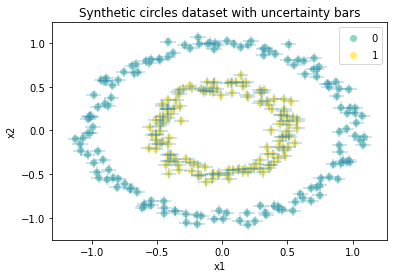

In [11]:
x_var = 3e-2**2
x, y = sklearn.datasets.make_circles(n_samples=300, factor=.5,
                                     noise=.05, random_state=1)
plt.errorbar(x[:,0], x[:,1], yerr=1.96*x_var**0.5, xerr=1.96*x_var**0.5, fmt='none', alpha=0.3)
scatter = plt.scatter(x[:,0], x[:,1], c=y, cmap='Set3')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements())
plt.title('Synthetic circles dataset with uncertainty bars')

We need to train a classifier (which is analagous to one a bank may be using to approve or reject loans) and fit a VAE.

In [4]:
data = (x, y.reshape(-1, 1))

input_dim = 2
hidden_widths = [100]
hidden_activation = Relu
output_dim = 1
output_activation = Sigmoid

classifier = create_mlp(
    rng_key, input_dim, hidden_widths, hidden_activation, output_dim, output_activation)
classifier, history = classifier.fit(binary_crossentropy_loss, data, step_size=1e-2, max_iter=200)

In [5]:
data = x
data_vari = x_var

latent_dim = 2

enc_params = {
    'input_dim': 2,
    'hidden_widths': [64],
    'activation_fn': Elu,
    'output_dim': latent_dim * 2
}
dec_params = {
    'input_dim': 2,
    'hidden_widths': [64],
    'activation_fn': Elu,
    'output_dim': 2
}

vae = create_vae(rng_key, enc_params, dec_params)
vae, loss_history = vae.fit(rng_key, data, data_vari, step_size=1e-2, max_iter=500)

Let's pick an individual point for recourse and see how the gradient update steps move with respect to different fields.

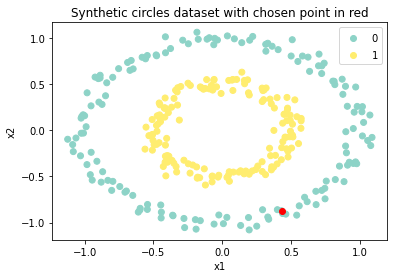

In [12]:
chosen_point = x[y == 0][[0],:]
scatter = plt.scatter(x[:,0], x[:,1], c=y, cmap='Set3')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements())
plt.title('Synthetic circles dataset with chosen point in red')
_ = plt.scatter(chosen_point[:,0], chosen_point[:,1], color='red')

In [7]:
revisor = Revise(classifier, vae)
min_prob_target = 0.9
paths = revisor.shortest_path_to_target_class(
    chosen_point, learning_rate=1e-2, max_iter=500, dist_weight=1e-4, 
    min_prob_target=min_prob_target)
# We don't stop early because we've generalized this to handle many chosen points at once.
trimmed_paths = [trim_path(p, min_prob_target=min_prob_target) for p in paths]

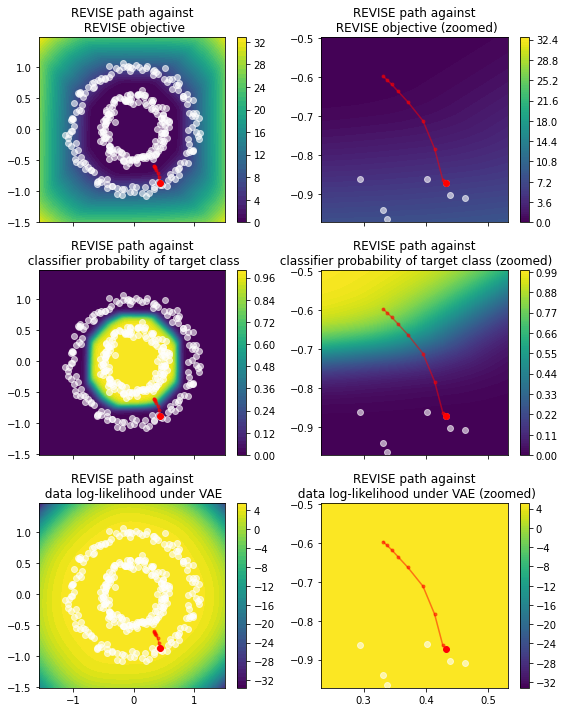

In [8]:
path = trimmed_paths[0]
fig, axes = plt.subplots(3, 2, figsize=(8, 10), sharex='col', sharey=False)
revisor.show_path(path, x, ax=axes[0][0], fig=fig, landscape='loss')
revisor.show_path(path, x, ax=axes[0][1], fig=fig, landscape='loss', zoom=True)
revisor.show_path(path, x, ax=axes[1][0], fig=fig, landscape='prob_target')
revisor.show_path(path, x, ax=axes[1][1], fig=fig, landscape='prob_target', zoom=True)
revisor.show_path(path, x, ax=axes[2][0], fig=fig, landscape='likelihood')
revisor.show_path(path, x, ax=axes[2][1], fig=fig, landscape='likelihood', zoom=True)
fig.tight_layout()

REVISE looks well-behaved in this particular problem. (We should note the that REVISE objective shown in the top left graph omits the distance term to allow for a more general depiction.) Let's visualize the final positions if we were to start at every point with a 0 label.

In [13]:
revisor = Revise(classifier, vae)
min_prob_target = 0.9
chosen_points = x[y == 0]
paths = revisor.shortest_path_to_target_class(
    chosen_points, learning_rate=1e-2, max_iter=500, dist_weight=1e-4, 
    min_prob_target=min_prob_target)
trimmed_paths = [trim_path(p, min_prob_target=min_prob_target) for p in paths]

Text(0, 0.5, 'x2')

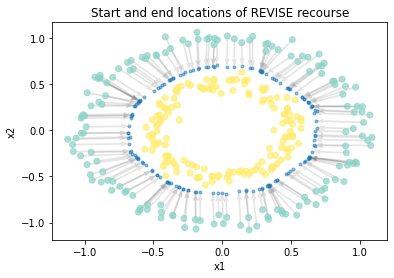

In [15]:
end_coords = np.array([(p.x[0],p.x[-1]) for p in trimmed_paths])
first_x, first_y = end_coords[:,0,0], end_coords[:,0,1]
last_x, last_y = end_coords[:,1,0], end_coords[:,1,1]
plt.quiver(first_x, first_y, last_x-first_x, last_y-first_y, 
           angles='xy', scale_units='xy', scale=1, alpha=0.1, width=5e-3)
plt.scatter(x[:,0], x[:,1], c=y, cmap='Set3', alpha=0.7)
plt.scatter(last_x, last_y, alpha=0.5, marker='.')
plt.title('Start and end locations of REVISE recourse')
plt.xlabel('x1')
plt.ylabel('x2')

This also looks pretty reasonable. We can see that few of the points are actually entering the distribution of the $y=1$ points, but they're close.

Let's look at another synthetic dataset: half moons.

Text(0.5, 1.0, 'Synthetic moons dataset with uncertainty bars')

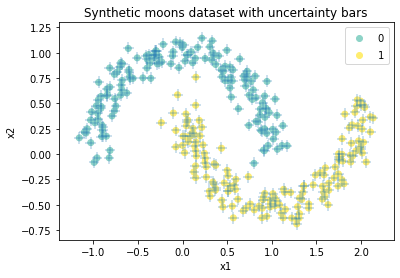

In [68]:
x_var = 3e-2**2
x, y = sklearn.datasets.make_moons(n_samples=300,
                                     noise=0.1, random_state=1)
plt.errorbar(x[:,0], x[:,1], yerr=1.96*x_var**0.5, xerr=1.96*x_var**0.5, fmt='none', alpha=0.3)
scatter = plt.scatter(x[:,0], x[:,1], c=y, cmap='Set3')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(*scatter.legend_elements())
plt.title('Synthetic moons dataset with uncertainty bars')

Train the classifier:

In [69]:
data = (x, y.reshape(-1, 1))

input_dim = 2
hidden_widths = [100]
hidden_activation = Relu
output_dim = 1
output_activation = Sigmoid

classifier = create_mlp(
    rng_key, input_dim, hidden_widths, hidden_activation, output_dim, output_activation)
classifier, history = classifier.fit(binary_crossentropy_loss, data, step_size=1e-2, max_iter=200)

Fit the VAE:

In [70]:
data = x
data_vari = x_var

latent_dim = 2

enc_params = {
    'input_dim': 2,
    'hidden_widths': [64],
    'activation_fn': Elu,
    'output_dim': latent_dim * 2
}
dec_params = {
    'input_dim': 2,
    'hidden_widths': [64],
    'activation_fn': Elu,
    'output_dim': 2
}

vae = create_vae(rng_key, enc_params, dec_params)
vae, loss_history = vae.fit(rng_key, data, data_vari, step_size=1e-2, max_iter=500)

Run REVISE:

In [71]:
revisor = Revise(classifier, vae)
min_prob_target = 0.9
chosen_points = x[y == 0]
paths = revisor.shortest_path_to_target_class(
    chosen_points, learning_rate=1e-2, max_iter=500, dist_weight=1e-4, 
    min_prob_target=min_prob_target)
# We don't stop early because we've generalized this to handle many chosen points at once.
trimmed_paths = [trim_path(p, min_prob_target=min_prob_target) for p in paths]

Plot the REVISE paths:

Text(0, 0.5, 'x2')

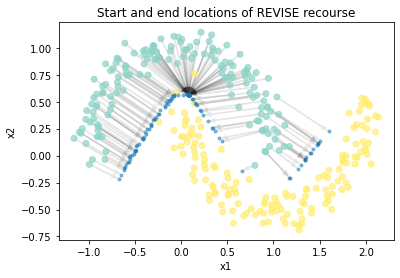

In [72]:
end_coords = np.array([(p.x[0],p.x[-1]) for p in trimmed_paths])
first_x, first_y = end_coords[:,0,0], end_coords[:,0,1]
last_x, last_y = end_coords[:,1,0], end_coords[:,1,1]
plt.quiver(first_x, first_y, last_x-first_x, last_y-first_y, 
           angles='xy', scale_units='xy', scale=1, alpha=0.1, width=5e-3)
plt.scatter(x[:,0], x[:,1], c=y, cmap='Set3', alpha=0.7)
plt.scatter(last_x, last_y, alpha=0.5, marker='.')
plt.title('Start and end locations of REVISE recourse')
plt.xlabel('x1')
_ = plt.ylabel('x2')

We can see that the points to the left are sitting in a low probability space - one of the issues that the CRUDS paper identified. We can see that this is due to the geometry of the decision boundary:

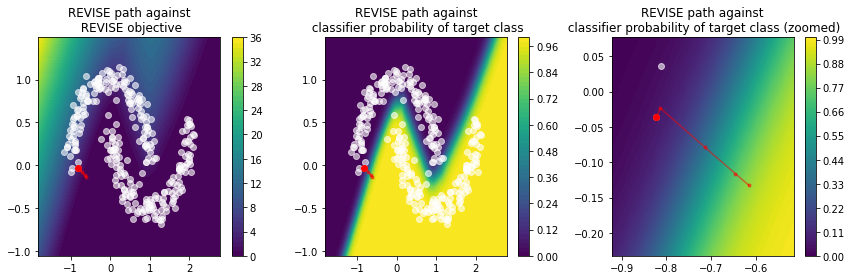

In [73]:
path = trimmed_paths[4]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex='col', sharey=False)
revisor.show_path(path, x, ax=axes[0], fig=fig, landscape='loss')
revisor.show_path(path, x, ax=axes[1], fig=fig, landscape='prob_target')
revisor.show_path(path, x, ax=axes[2], fig=fig, landscape='prob_target', zoom=True)

fig.tight_layout()

Next, we move on to data that is a bit less abstract.

We started by thinking about the type of data we would like to analyze with REVISE. We wanted to know exactly how data was being generated and how decisions were being made, so we first wrote some code to generate a dataset for us. This data generation code is fairly general and allows a user to define attributes to generate from a sample space as well as a function that makes a True/False decision.

We use this framework to generate an artificial loan approval/rejection dataset, where decisions are made based on credit score, education, salary, age, and debt to salary ratio, which we thought seemed relatively realistic.

In [33]:
def generate_data(generator, y_name, decider, n = 100):
  '''This function provides a general framework to generate artificial datasets.
  The user defines a 'generator' and 'decider' which generate an individual
  data point and then decide if the response for this variable is positive or
  negative (0/1). Generator should return a dictionary of individual attributes,
  and decider should accept the individual dictionary as a parameter and return
  a 0/1 based on the individual's attributes.
  '''
  data = []

  for i1 in range(n):
    datum = generator()

    datum[y_name] = decider(datum)

    data.append(datum)

  return pd.DataFrame(data)

In [34]:
# CONSTANTS
AGE_MIN = 20
AGE_MAX = 80

SEX = ['male', 'female']

# https://grants.nih.gov/grants/guide/notice-files/not-od-15-089.html
RACE = ['American Indian or Alaska Native',
        'Asian',
        'Black or African American',
        'Hispanic or Latino',
        'Native Hawaiian or Other Pacific Islander',
        'White']

# Generalize credit score to the five ranges
# 300-579: Poor.
# 580-669: Fair.
# 670-739: Good.
# 740-799: Very good.
# 800-850: Excellent.
CREDIT_SCORE = ['poor', 'fair', 'good', 'very good', 'excellent']

# Generalize education to three levels, much more complex in real world
EDUCATION = ['high school', 'college', 'graduate school']

# Generalize loan amnt to three buckets
LOAN_AMOUNT = ['low', 'medium', 'high']

def insurance_generator():
  '''Generate an individual included in the insurance dataset.'''
  return {
      'age': np.random.randint(AGE_MIN, AGE_MAX)/100.0,
      'sex': np.random.choice(SEX),
      'race': np.random.choice(RACE),
      'credit_score': np.random.choice(CREDIT_SCORE),
      'education': np.random.choice(EDUCATION),
      'salary': np.random.choice(range(100, 20000))/10000.0,
      'debt': np.random.choice(range(0, 15000))/10000.0,
      'married': round(np.random.random()), # 0 or 1
      'loan_amount': np.random.choice(LOAN_AMOUNT)
  }

def random_decider(individual):
    d2i = (individual['debt']/individual['salary'])
    if d2i >= 1.0 or individual['credit_score'] == 'poor' or (individual['education'] == 'high school' and individual['salary'] <= 0.1):
        return 0
    if individual['age'] >= 0.67:
        return np.random.choice([0,1], p=[0.7, 0.3])
    return 1


In [35]:
loandata = generate_data(insurance_generator, 'loan_approved', random_decider, n = 1000)
loandata.head()

,age,sex,race,credit_score,education,salary,debt,married,loan_amount,loan_approved
0,0.54,female,American Indian or Alaska Native,fair,high school,1.6553,0.7040,0,high,1
1,0.34,female,Native Hawaiian or Other Pacific Islander,good,high school,0.1220,1.3276,0,low,0
2,0.52,male,Black or African American,poor,graduate school,0.1308,0.0342,0,high,0
3,0.28,female,Hispanic or Latino,fair,college,1.5273,0.7696,1,medium,1
4,0.30,female,Black or African American,poor,high school,0.3999,0.4356,1,medium,0


In [37]:
# Only get two of the numeric attributes from the dataset
xl = loandata[['age','salary']].to_numpy()
yl = loandata['loan_approved'].to_numpy()

data = xl
data_vari = np.var(xl).sum()

rng_key = random.PRNGKey(0)
latent_dim = 2

enc_params = {
    'input_dim': 2,
    'hidden_widths': [64, 64],
    'activation_fn': Relu,
    'output_dim': latent_dim * 2
}
dec_params = {
    'input_dim': 2,
    'hidden_widths': [64, 64],
    'activation_fn': Relu,
    'output_dim': 2
}

vae = create_vae(rng_key, enc_params, dec_params)
vae, loss_history = vae.fit(rng_key, data, data_vari, step_size=1e-3, max_iter=500)

In [38]:
# Build classifier
data = (xl, yl.reshape(-1, 1))

input_dim = 2
hidden_widths = [100]
hidden_activation = Relu
output_dim = 1
output_activation = Sigmoid

classifier = create_mlp(
    rng_key, input_dim, hidden_widths, hidden_activation, output_dim, output_activation)
classifier, history = classifier.fit(binary_crossentropy_loss, data, step_size=1e-2, max_iter=200)

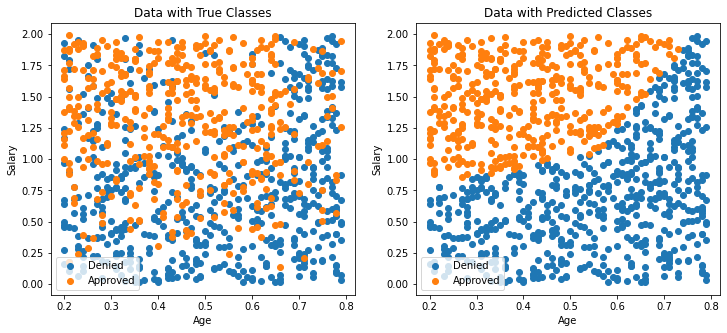

In [42]:
preds = (classifier.predict(xl) > 0.5).reshape(-1)

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.scatter(xl[:, 0][yl == 0], xl[:, 1][yl == 0], label = 'Denied')
plt.scatter(xl[:, 0][yl == 1], xl[:, 1][yl == 1], label = 'Approved')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.title('Data with True Classes')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(xl[:, 0][preds == 0], xl[:, 1][preds == 0], label = 'Denied')
plt.scatter(xl[:, 0][preds == 1], xl[:, 1][preds == 1], label = 'Approved')
plt.xlabel('Age')
plt.ylabel('Salary')
plt.title('Data with Predicted Classes')
plt.legend()

# We can see that our classifier prefers younger, higher salary individuals
# which is what we said in random_decider above.

array([[0.3   , 0.3999]])

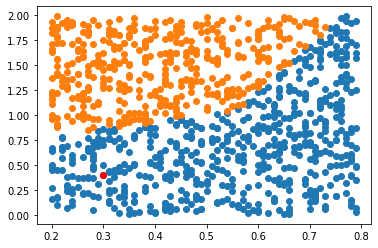

In [46]:
# Pick a point for recourse
recourse_point = xl[preds == 0][[2]]
plt.scatter(xl[:, 0][preds == 0], xl[:, 1][preds == 0], label = 'Denied')
plt.scatter(xl[:, 0][preds == 1], xl[:, 1][preds == 1], label = 'Approved')
plt.scatter(recourse_point[:,0], recourse_point[:,1], c = 'red')

recourse_point

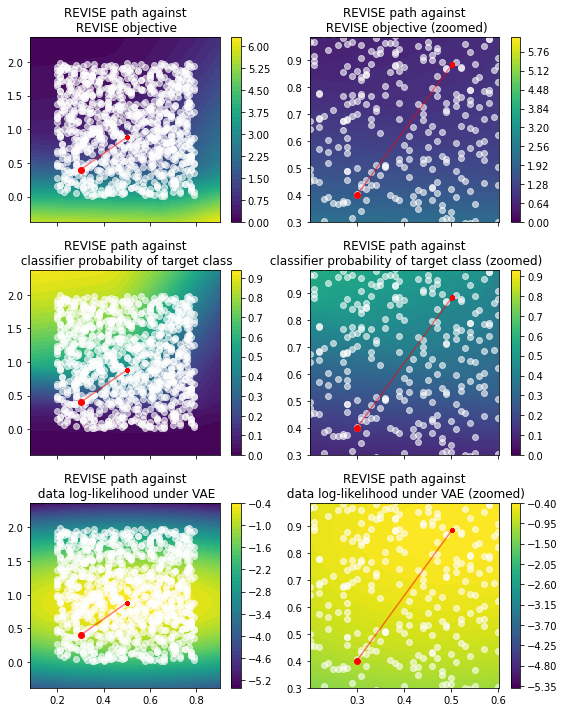

In [52]:
# Plot path for this individual point
revisor = Revise(classifier, vae)
paths = revisor.shortest_path_to_target_class(recourse_point, learning_rate=1e-3, max_iter=500)
path = paths[0]
fig, axes = plt.subplots(3, 2, figsize=(8, 10), sharex='col', sharey=False)
revisor.show_path(path, xl, ax=axes[0][0], fig=fig)
revisor.show_path(path, xl, ax=axes[0][1], fig=fig, zoom=True)
revisor.show_path(path, xl, ax=axes[1][0], fig=fig, landscape='prob_target')
revisor.show_path(path, xl, ax=axes[1][1], fig=fig, landscape='prob_target', zoom=True)
revisor.show_path(path, xl, ax=axes[2][0], fig=fig, landscape='likelihood')
revisor.show_path(path, xl, ax=axes[2][1], fig=fig, landscape='likelihood', zoom=True)
fig.tight_layout()



The path recommended by revise basically tells the individual to have a higher salary.
We see age (on the x-axis) goes up a bit along the path, but it seems like the most important variable in determining approval for the loan is your salary.

### Extensions to REVISE

While the reliance on gradients is a real issue for REVISE that is solved fully by CRUDS, we explored extending REVISE a little bit as a learning exercise. 
Specifically, we approached the problem that the new feature set found by REVISE may have a different target label but be of low probability. This was best exhibited in the CRUDS paper by data consisting of two Gaussian blobs:

Text(0, 0.5, 'x2')

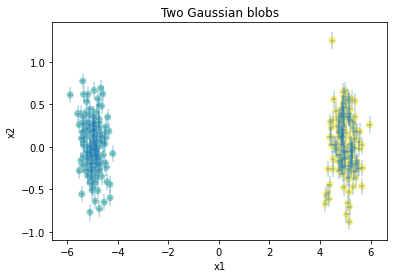

In [75]:
x_var = 5e-2**2
x, y = sklearn.datasets.make_blobs(
    n_samples=300, n_features=2, 
    centers=([-5, 0.0], [5, 0.0]), cluster_std=0.1**0.5, random_state=1)
plt.errorbar(x[:,0], x[:,1], yerr=1.96*x_var**0.5, xerr=1.96*x_var**0.5, fmt='none', alpha=0.3)
plt.scatter(x[:,0], x[:,1], c=y, cmap='Set3')
plt.title('Two Gaussian blobs')
plt.xlabel('x1')
plt.ylabel('x2')

We'll skip through and show the final locations of the points after running REVISE.

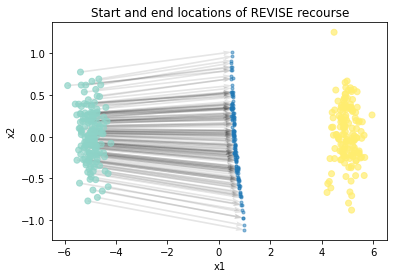

In [81]:
### Classifier
data = (x, y.reshape(-1, 1))

input_dim = 2
hidden_widths = [100]
hidden_activation = Relu
output_dim = 1
output_activation = Sigmoid

classifier = create_mlp(
    rng_key, input_dim, hidden_widths, hidden_activation, output_dim, output_activation)
classifier, history = classifier.fit(binary_crossentropy_loss, data, step_size=1e-2, max_iter=200)

### VAE
data = x
data_vari = x_var

latent_dim = 2

enc_params = {
    'input_dim': 2,
    'hidden_widths': [64, 64, 64],
    'activation_fn': Elu,
    'output_dim': latent_dim * 2
}
dec_params = {
    'input_dim': 2,
    'hidden_widths': [64, 64, 64],
    'activation_fn': Elu,
    'output_dim': 2
}

vae = create_vae(rng_key, enc_params, dec_params)
vae, loss_history = vae.fit(rng_key, data, data_vari, step_size=1e-2, max_iter=500)

### REVISE
chosen_points = x[y==0]
revisor = Revise(classifier, vae)
paths = revisor.shortest_path_to_target_class(
    chosen_points, learning_rate=1e-2, max_iter=500, dist_weight=1e-4, 
    min_prob_target=min_prob_target)
trimmed_paths = [trim_path(p, min_prob_target=min_prob_target) for p in paths]

### Plotting
end_coords = np.array([(p.x[0],p.x[-1]) for p in trimmed_paths])
first_x, first_y = end_coords[:,0,0], end_coords[:,0,1]
last_x, last_y = end_coords[:,1,0], end_coords[:,1,1]
plt.quiver(first_x, first_y, last_x-first_x, last_y-first_y, 
           angles='xy', scale_units='xy', scale=1, alpha=0.1, width=5e-3)
plt.scatter(x[:,0], x[:,1], c=y, cmap='Set3', alpha=0.7)
plt.scatter(last_x, last_y, alpha=0.5, marker='.')
plt.title('Start and end locations of REVISE recourse')
plt.xlabel('x1')
_ = plt.ylabel('x2')

This recreates the behavior seen in the CRUDS paper. We can see why this occurs more clearly when looking at the paths against the REVISE objective and the decision boundary:

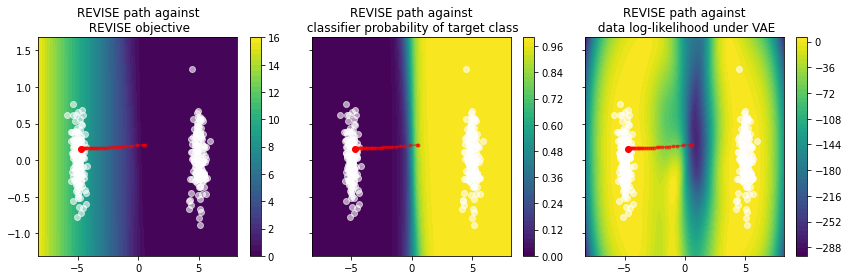

In [85]:
path = trimmed_paths[4]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex='col', sharey=True)
revisor.show_path(path, x, ax=axes[0], fig=fig, landscape='loss')
revisor.show_path(path, x, ax=axes[1], fig=fig, landscape='prob_target')
revisor.show_path(path, x, ax=axes[2], fig=fig, landscape='likelihood')
fig.tight_layout()

The third graph shows the problem: our new recourse point is of low probability and the VAE knows it. REVISE can't know it because the REVISE objective isn't informed by the VAE data likelihood in any way, so after the path descends the REVISE objective, it finds itself in a vast wasteland.

One idea to help remedy this situation is to bolt the negative of the right half of the VAE data density onto the REVISE objective weighted by some hyperparameter. Then, we alter the stopping condition to require a minimum data probability as well as a minimum target class probability:

In [86]:
min_prob_data = 0.9
paths = revisor._blended_shortest_path_to_target_class(
    chosen_points, learning_rate=1e-2, max_iter=500, dist_weight=1e-4, 
    min_prob_target=min_prob_target, min_prob_data=min_prob_data)

trimmed_paths = [
    trim_path(p, min_prob_target=min_prob_target, min_prob_data=min_prob_data) 
    for p in paths]

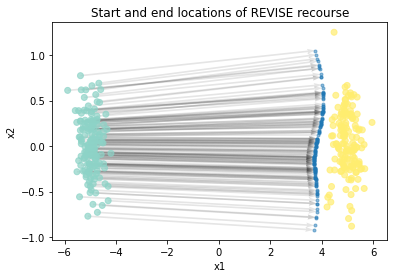

In [88]:
end_coords = np.array([(p.x[0],p.x[-1]) for p in trimmed_paths])
first_x, first_y = end_coords[:,0,0], end_coords[:,0,1]
last_x, last_y = end_coords[:,1,0], end_coords[:,1,1]
plt.quiver(first_x, first_y, last_x-first_x, last_y-first_y, 
           angles='xy', scale_units='xy', scale=1, alpha=0.1, width=5e-3)
plt.scatter(x[:,0], x[:,1], c=y, cmap='Set3', alpha=0.7)
plt.scatter(last_x, last_y, alpha=0.5, marker='.')
plt.title('Start and end locations of REVISE recourse')
plt.xlabel('x1')
_ = plt.ylabel('x2')

We can look at the path lengths to make sure we're actually hitting the stopping conditions and not just running out the `max_iters`:

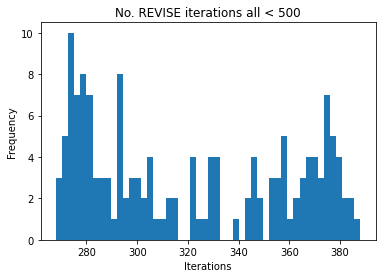

In [96]:
ax = pd.Series([len(p.x) for p in trimmed_paths]).plot.hist(bins=50, title='No. REVISE iterations all < 500')
_ = ax.set_xlabel('Iterations')

Let's just take a quick look at a single example to see how the gradient interacts with the various fields we've been looking at:

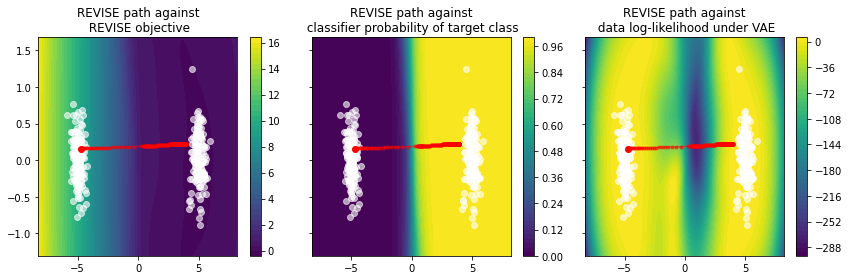

In [98]:
path = trimmed_paths[4]
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex='col', sharey=True)
revisor.show_path(path, x, ax=axes[0], fig=fig, landscape='blended_loss')
revisor.show_path(path, x, ax=axes[1], fig=fig, landscape='prob_target')
revisor.show_path(path, x, ax=axes[2], fig=fig, landscape='likelihood')
fig.tight_layout()

## Future Work

When thinking about CRUDS use in practice, we're often thinking in the context of loan approval. Specifically, we're thinking about a bank using CRUDS to help council people that have been denied a loan. The fact that CRUDS outputs multiple candidate recourse paths helps ensure at least one recourse will be causally possible, but right now filtering out the implausible recourse is a manual procedure. Having a bank or customers do this manual filtering at scale is impractical. A fairly simple extension would be to use [constraint programming](https://developers.google.com/optimization/cp) to perform this filtering automatically.

Moreover, in 'Broader Impacts' we mentioned that the possible range of the three $\beta$ hyperparameters is not mathematically defined. 
The absence of formal justification for these parameters signifies that the training process could be different for every application. That the quality of counterfactuals could depend on hyperparameters could undermine the credibility of the model. 
 Also, fickleness of the adversarial optimization also exacerbates the training challenges. The alternating training process does not always guarantee convergence to an optima because neither of the two optimizers acheives an optima unless their counterpart does.
 To be more precise, a coincidental improvement in approximating $q_{delta}(\vec{y}|\vec{z})$ has to happen at some point in the mini-max iteration for both the encoder and the decoder to takeoff and continuously improve each other.
A possible extension would be to address these

## Bonus CSVAE

We had a secondary objective of implementing our own CSVAE. 
This seemed like too much of a lift at the beginning of the project, but by the end we were capable enough to implement a basic CSVAE. 
This wasn't finished in time to use for the experiments above, but we hope to use it for further research in the future. Our implementation was informed by [two](https://github.com/qq456cvb/CSVAE) [existing](https://github.com/alexlyzhov/latent-subspaces) implementations.

In [53]:
from jax_csvae import create_csvae

rng_key = random.PRNGKey(0)

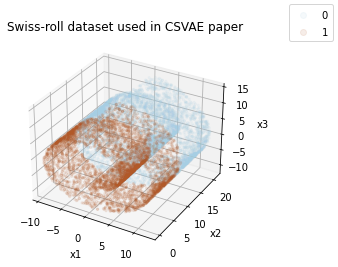

In [55]:
X, _ = sklearn.datasets.make_swiss_roll(10000)
y = (X[:, 1] < 10).astype('int32')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='.', alpha=0.1, c=y, cmap='Paired')
ax.set_title('Swiss-roll dataset used in CSVAE paper')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')
fig.legend(*scatter.legend_elements())

In [56]:
w_latent_dim = 2
z_latent_dim = 2

w_enc_params = {
    'input_dim': 4,
    'hidden_widths': [64, 64, 64],
    'activation_fn': Elu,
    'output_dim': w_latent_dim * 2
}
z_enc_params = {
    'input_dim': 3,
    'hidden_widths': [64, 64, 64],
    'activation_fn': Elu,
    'output_dim': z_latent_dim * 2
}
x_dec_params = {
    'input_dim': z_latent_dim + w_latent_dim,
    'hidden_widths': [64, 64, 64],
    'activation_fn': Elu,
    'output_dim': 3
}
y_dec_params = {
    'input_dim': z_latent_dim,
    'hidden_widths': [64, 64, 64],
    'activation_fn': Elu,
    'output_dim': 1,
    'output_activation_fn': Sigmoid
}

csvae = create_csvae(rng_key, w_enc_params, z_enc_params, x_dec_params, y_dec_params)

In [57]:
csvae, history = csvae.fit(rng_key, (X, y), step_size=1e-2, max_iter=100)

100%|██████████| 100/100 [01:55<00:00,  1.16s/it]


As can be seen below, we could have continued to train this to see improved losses, but this is enough for now.

Text(0.5, 0, 'Epoch')

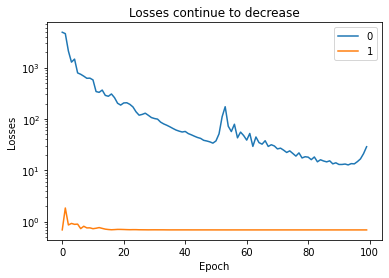

In [64]:
ax = pd.DataFrame(history, dtype='float32').plot.line(
    logy=True, title='Losses continue to decrease')
ax.set_ylabel('Losses')
ax.set_xlabel('Epoch')

Let's see if the projection of data points onto $Z$ latent space captures the general outlook of the Swiss roll and the $W$ latent space geometrically separates them by their labels.

Text(0.5, 1.0, 'Projection of data into Z-space')

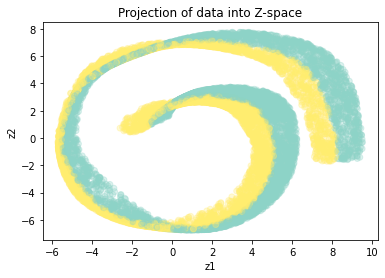

In [65]:
z = csvae.z_encode(X)
plt.scatter(z[:,0], z[:,1], c=y, cmap='Set3', alpha=0.3)
plt.xlabel('z1')
plt.ylabel('z2')
plt.title('Projection of data into Z-space')

Text(0.5, 1.0, 'Projection of data into W-space')

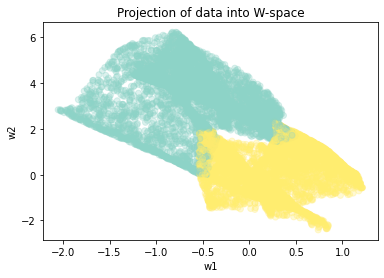

In [66]:
w = csvae.w_encode(np.hstack((X, y.reshape(-1, 1))))
plt.scatter(w[:,0], w[:,1], c=y, cmap='Set3', alpha=0.3)
plt.xlabel('w1')
plt.ylabel('w2')
plt.title('Projection of data into W-space')

# Bibliography

1. *A survey of algorithmic recourse: definitions, formulations, solutions, and prospects*; Karimi, 
Scholkopf, Barthe, Valera; 2020; https://arxiv.org/pdf/2010.04050.pdf 

2. *Learning  latent  subspaces  in  variational  autoencoders*; Jack  Klys,  Jake  Snell,  and  Richard  S.  Zemel; 2018; CoRR, abs/1812.06190, 20*

3. *Towards Realistic Individual Recourse and Actionable Explanations in Black-Box Decision Making Systems*; Joshi, Koyejo, Vijitbenjaronk, Kim, Ghosh; 2019; https://arxiv.org/pdf/1907.09615.pdf